In [440]:
using Pkg

Pkg.activate("..")

using MiCRM_stability
using LinearAlgebra, KrylovKit
using StatsBase, Distances, Distributions
using CairoMakie, ColorSchemes
using DelimitedFiles
using Random
using Graphs, GraphMakie, NetworkLayout, SimpleWeightedGraphs
using LsqFit
using JLD2

  Activating project at `~/Projects/MiCRM_stability`


┌ Warning: Since there are a lot of edges (1076 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/cSPi5/src/recipes.jl:532
┌ Warning: Since there are a lot of edges (1084 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/cSPi5/src/recipes.jl:532
┌ Warning: Since there are a lot of edges (1068 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/cSPi5/src/reci

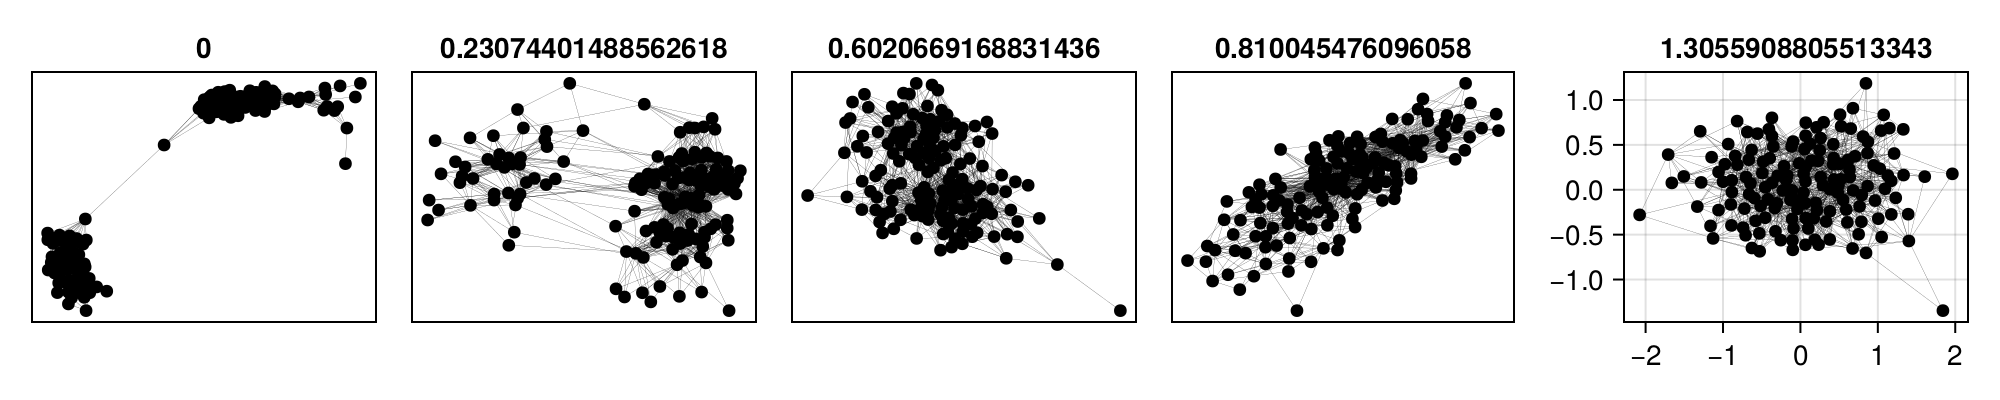

In [456]:
N,M = 50,100
C = 0.1
T = range(0.000001,1.0, length = 5)

f = Figure(size = (1000,200))

for i = 1:5
    hidedecorations!(ax)
    
    com = MiCRM_stability.attachment_community(N, M, C, T[i])
    A = MiCRM_stability.get_A(com)

    TL = MiCRM_stability.get_TL(A)

    nc = fill(RGBf(0.0,0.0,0.0), N+M)
    # nc[1:N] .= [RGBf(1.0,TL[i] / maximum(TL),1.0) for i = 1:N]
    # nc[(N+1):end] .= [RGBf(0.0,TL[i + N] / maximum(TL),0.0) for i = 1:M]

    TC = MiCRM_stability.get_TC(A)

    ax = Axis(f[1,i], title = "$TC")
    
    graphplot!(ax, DiGraph(A'), node_color = nc, nodesize = 20, layout = NetworkLayout.Spring(), edge_width = 0.1, arrow_size = false, title = "$TC")

    # text!(ax, (0.1,0.1), text = "$TC")

end

f

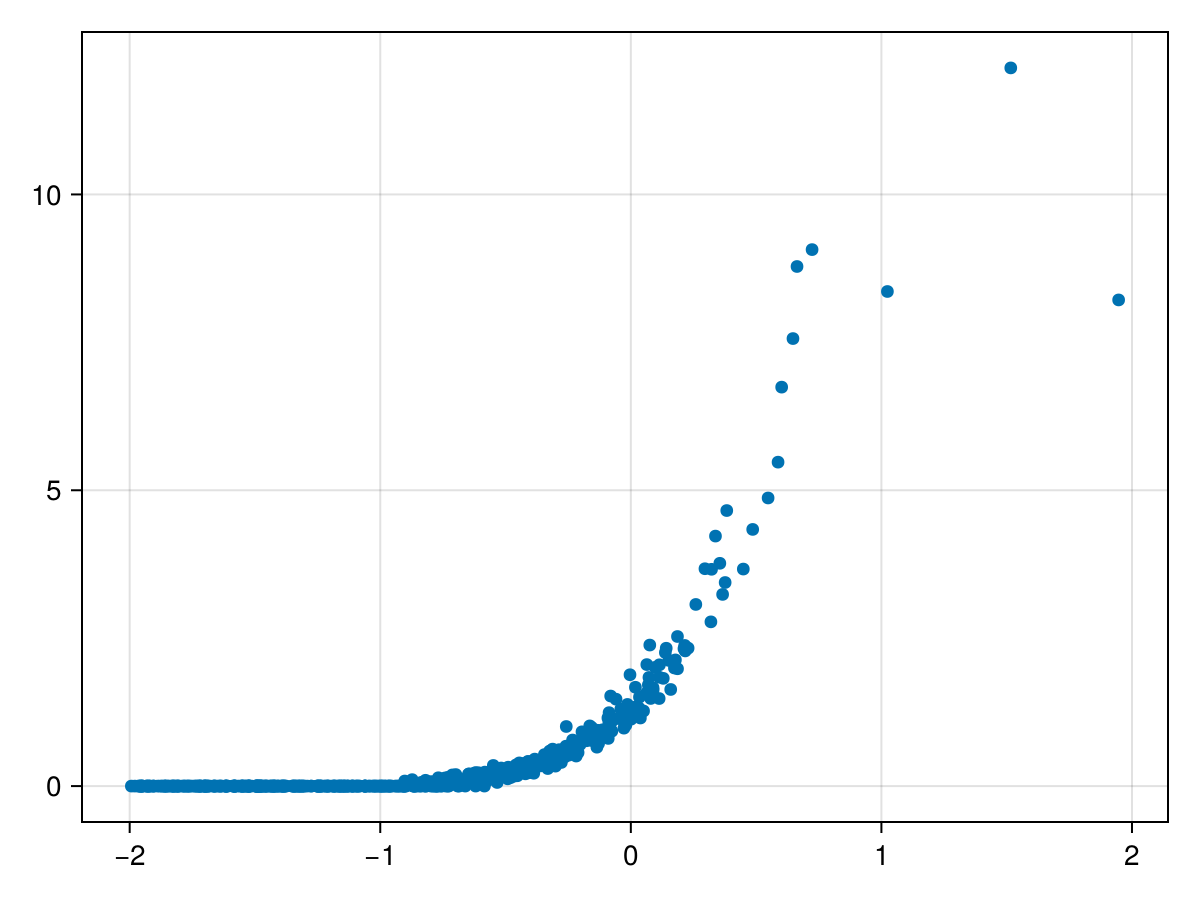

In [484]:
T_vec = 10 .^ rand(Uniform(-2,2), 1000)
TC_vec = similar(T_vec)
for i = eachindex(T_vec)
    com = MiCRM_stability.attachment_community(N, M, C, T_vec[i])
    A = MiCRM_stability.get_A(com)
    TC_vec[i] = MiCRM_stability.get_TC(A)
end

ind = TC_vec .< Inf

plot(log10.(T_vec)[ind], TC_vec[ind])


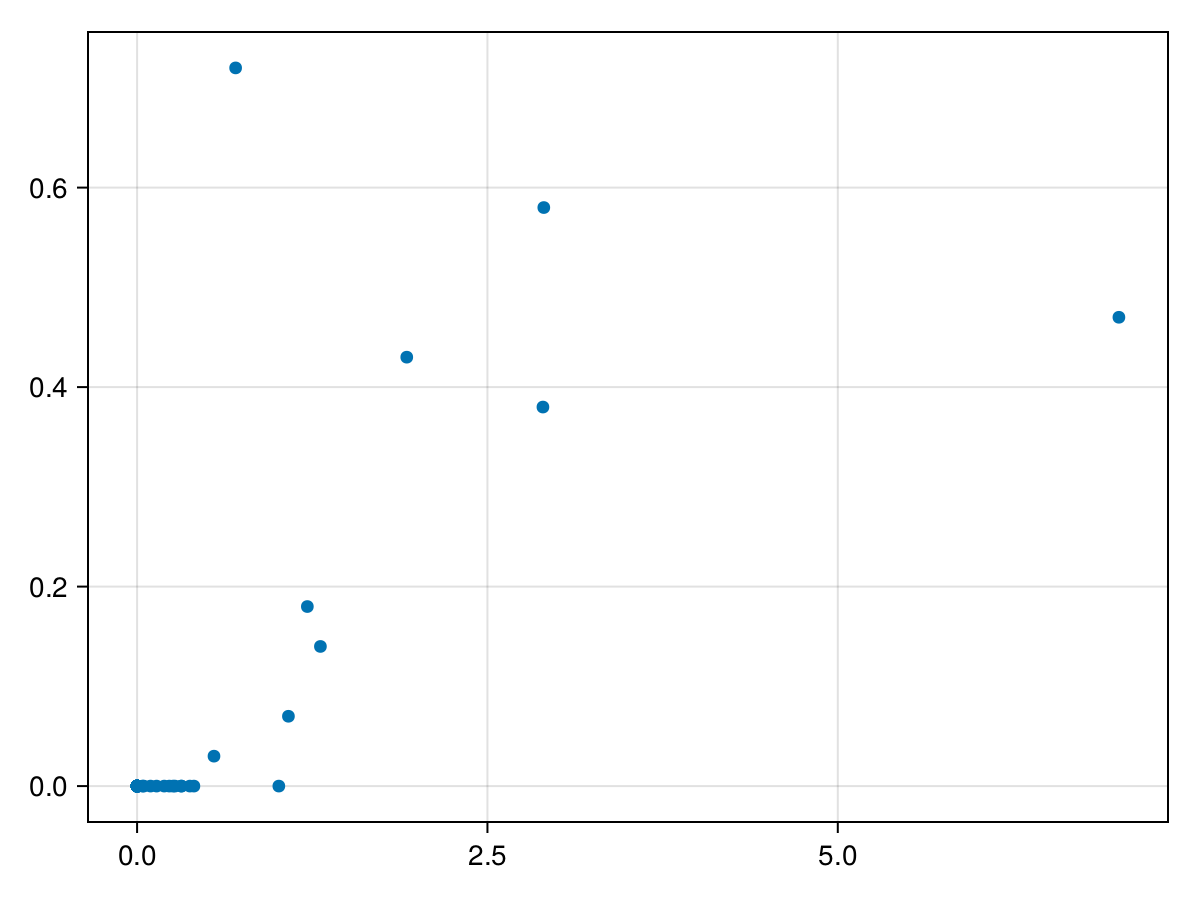

In [531]:
res = load("../Results/data/crossfeeding_stabiltiy.jld2");

l = mean(res["l"] .< 0 , dims = 2)
TC = [r[1] for r = res["p"]]
TC = mean(TC, dims = 2)

ind = TC .< Inf

f,ax = plot((TC[ind]), l[ind])



In [530]:
ind

100×1 BitMatrix:
 0
 1
 1
 0
 1
 1
 0
 1
 1
 1
 1
 1
 0
 ⋮
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 0
 1

In [521]:
function get_exponential_parameters(N,M,L)
    σ = 0.1
    gx = 0.9ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = -ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = 1.5ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M) #rand(Uniform(0,2)) .+ rand(Uniform(-σ,σ),N,M)
    hy = -ones(N,M) #rand(Uniform(-2,0)) .+ rand(Uniform(-σ,σ),N,M)
    
    λy = zeros(N,M) #rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    ωy = - λy .* (L / (1 - L))

    iy = zeros(M) 
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

N,M,C = 100,100,0.1

c = MiCRM_stability.attachment_community(N, M, C, 0.01)

sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M, Λ = 0)
ep = get_exponential_parameters(c.N, c.M, rand())
p = MiCRM_stability.Parameters(c.N,c.M,sp,ep)

J = zeros(N+M, N+M)
@time MiCRM_stability.jacobian!(p, J)

G = similar(J)
x0 = zeros(N+M)

@time MiCRM_stability.gc!(G,J,x0)


  0.007776 seconds
  0.051608 seconds (1.20 k allocations: 122.778 MiB)


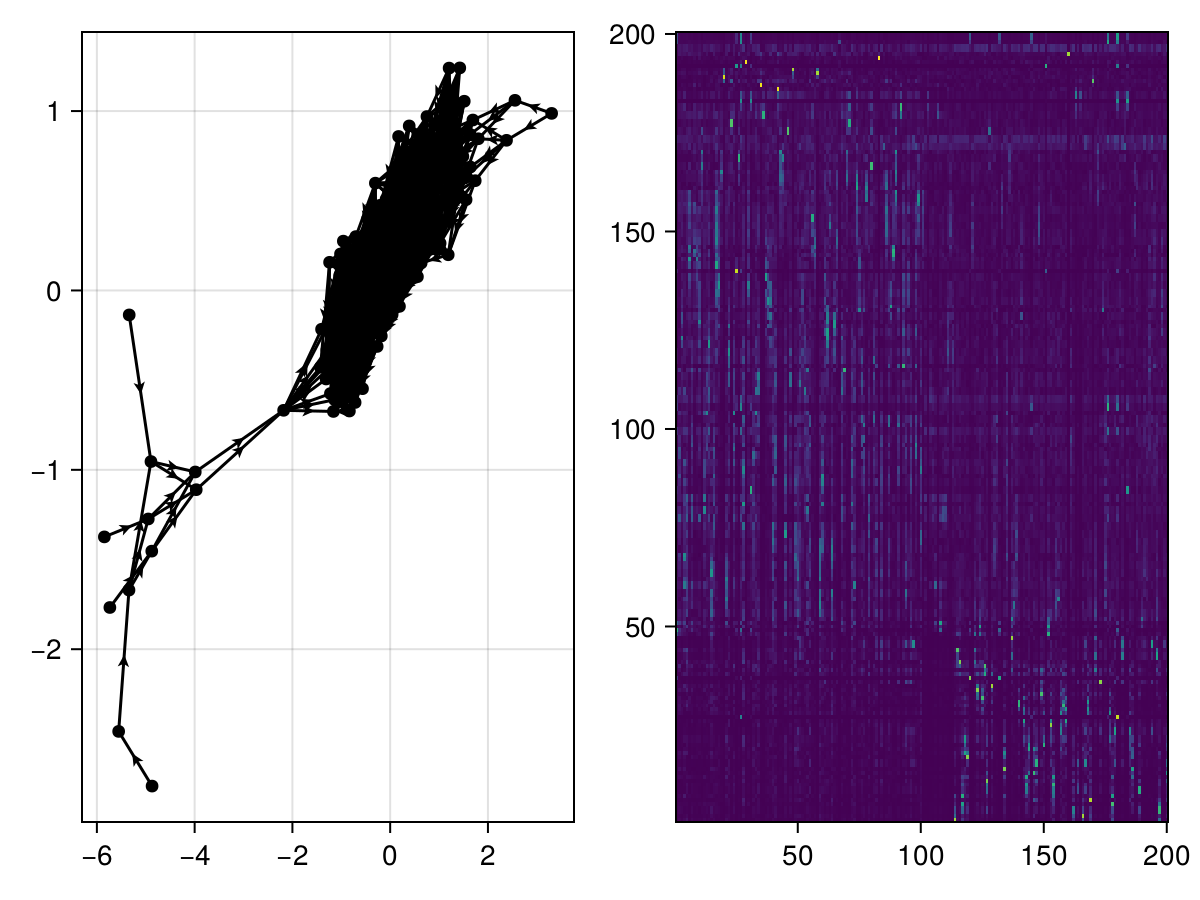

In [522]:
A = MiCRM_stability.get_A(c)

f,ax = graphplot(DiGraph(A))

plot!(Axis(f[1,2]), norm.(eigen(J).vectors))
f

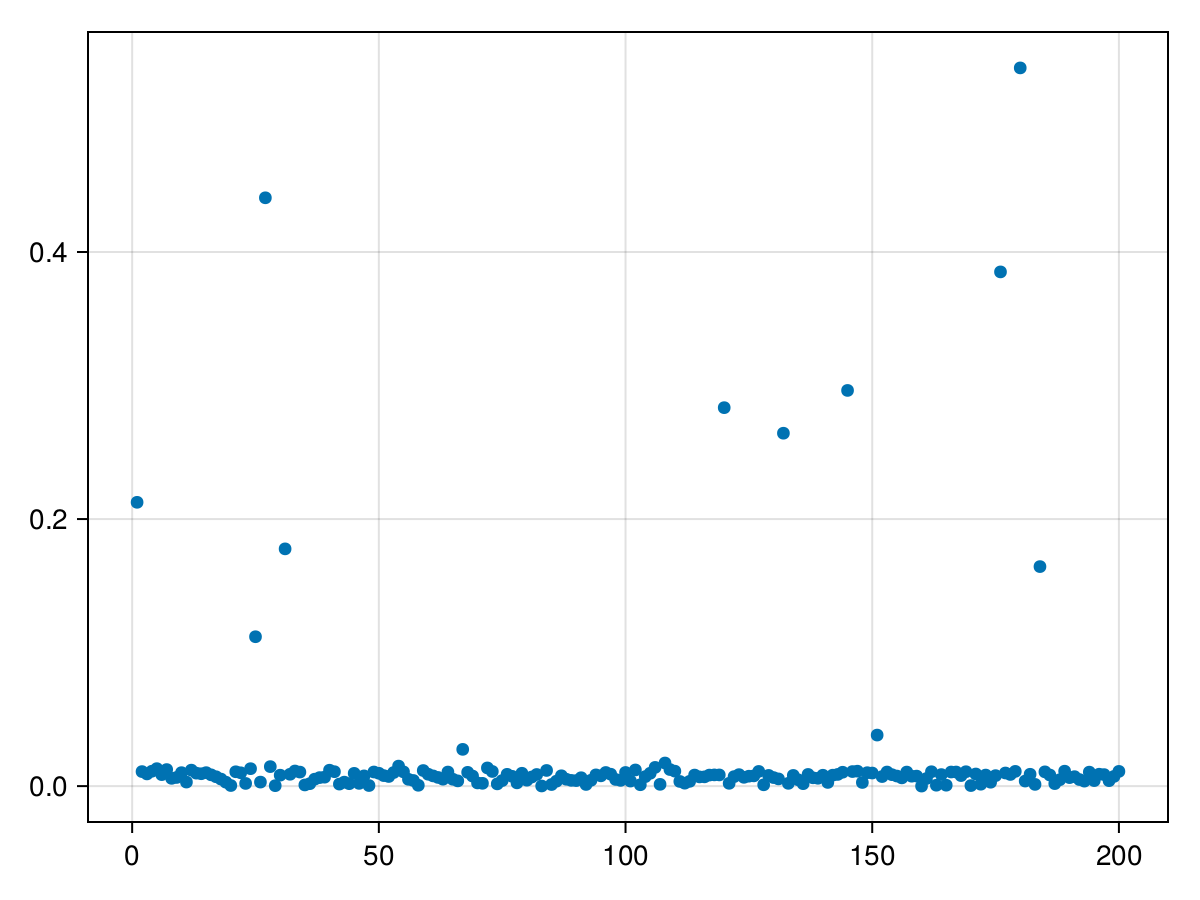

In [524]:
norm.(eigen(J).vectors)[:,end] |> plot

In [509]:
s = MiCRM_stability.get_TL(A) 

sN = s[1:N]
sM = s[N+1:end]

pa = (x,T) -> exp(-abs(x - 1) / T)

Udiff = sN .- sM'
Ldiff = sM .- sN'

U = (pa.(Udiff, 1) .*  0.1) .> rand(N,M)
L = (pa.(Ldiff', 1) .*  0.1) .> rand(N,M)

c.U .= min.(1, c.U .+ U)
c.L .= min.(1, c.L .+ L)

100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

┌ Warning: Since there are a lot of edges (2164 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/cSPi5/src/recipes.jl:532


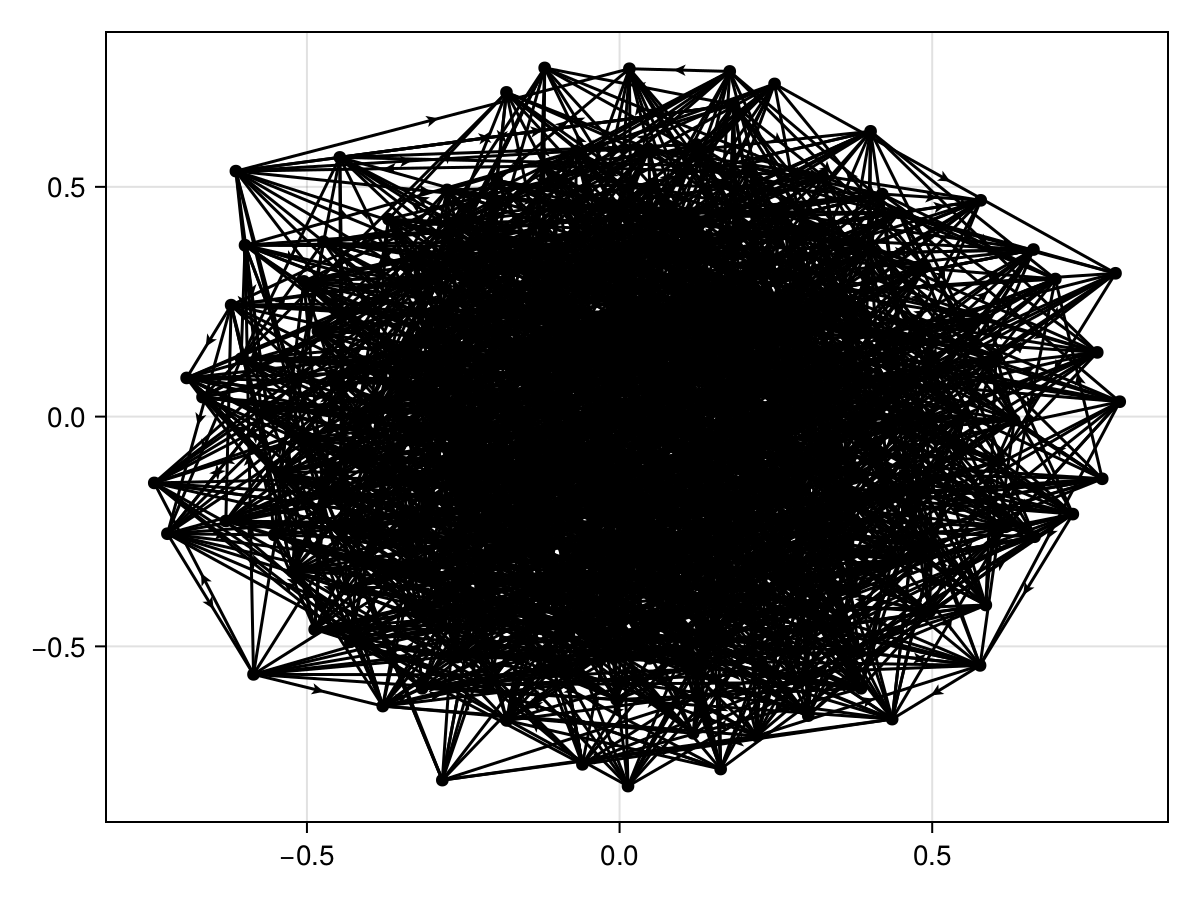

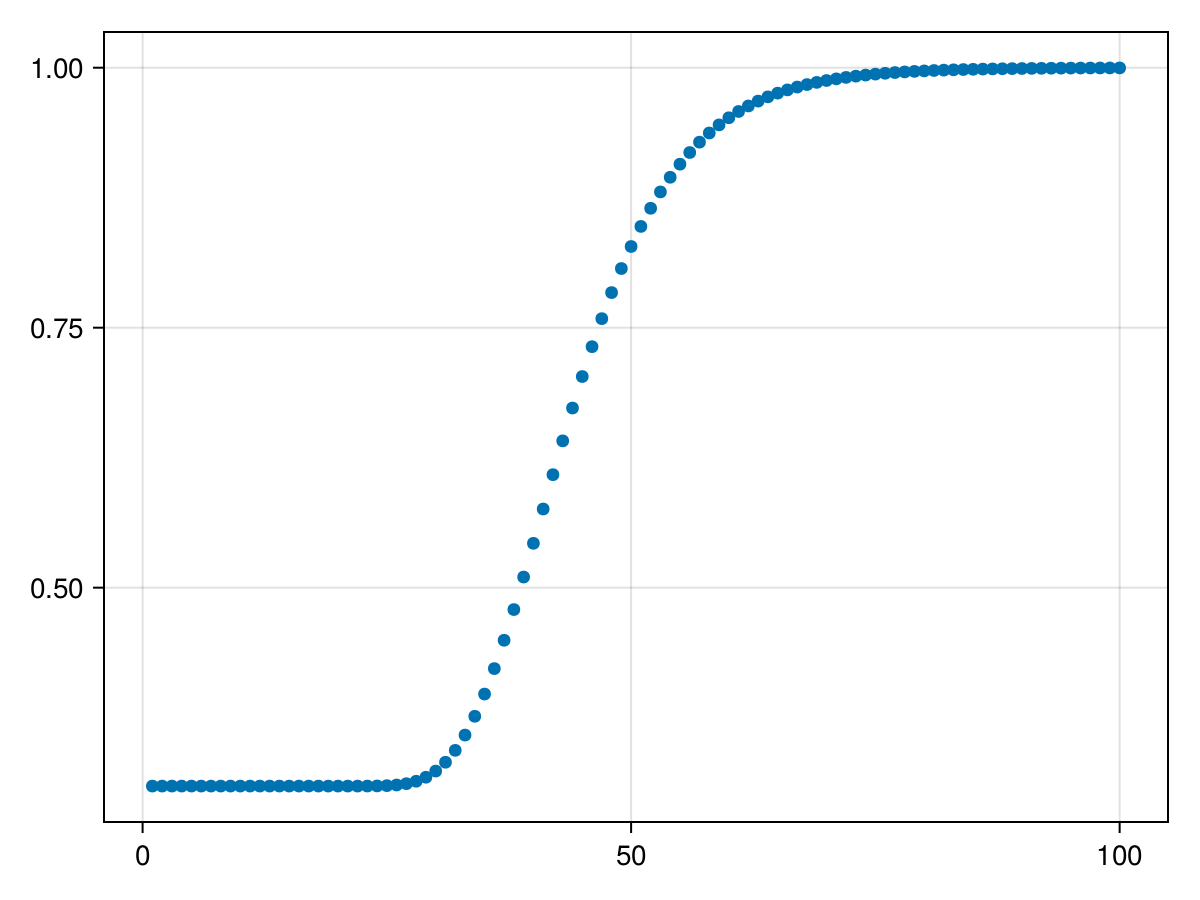

In [382]:

pU = [pa.(Udiff, t) for t = 10 .^ range(-2,4,length = 100)]

mean.(pU)  |> plot

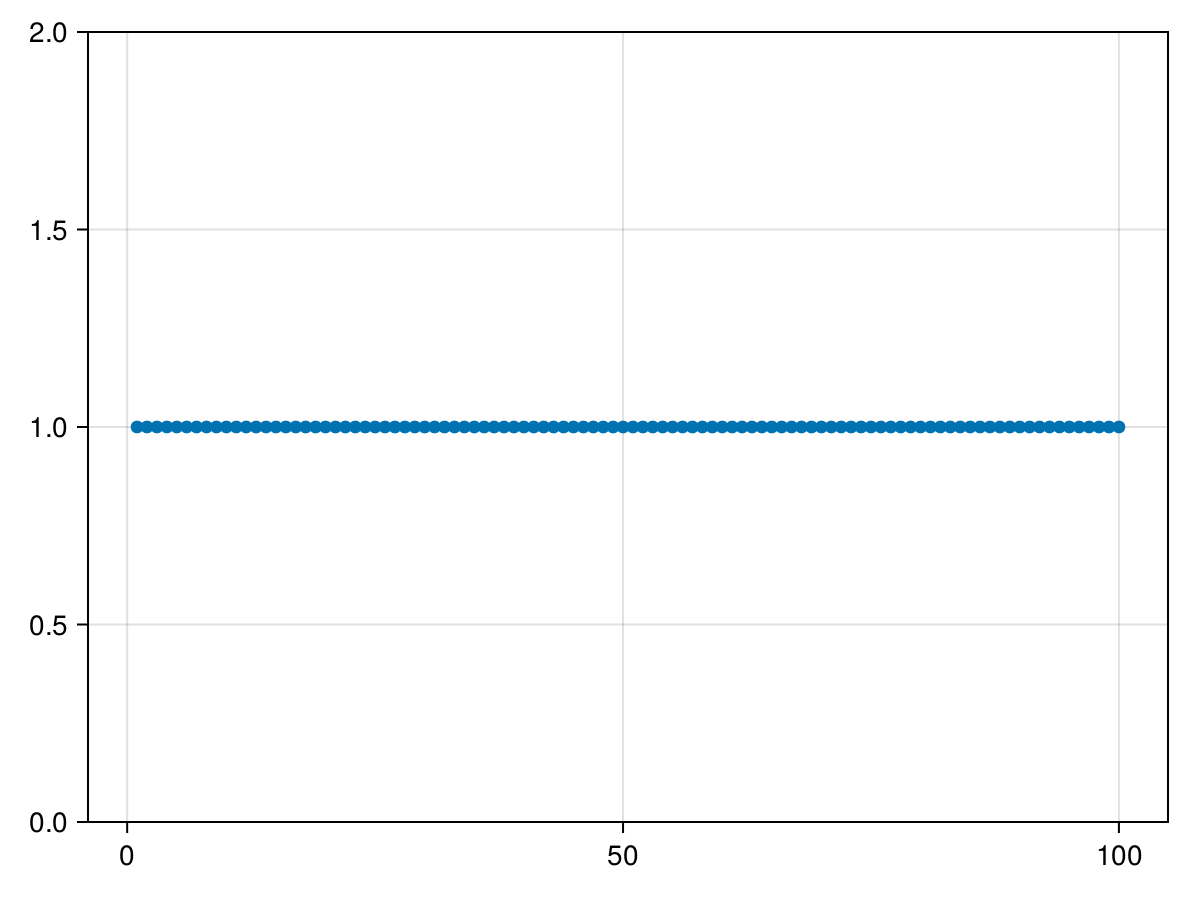

In [403]:
sum.(pU ./ (sum.(pU))) |> plot